## Installation of Packages and other settings

In [0]:
!--NotebookApp.iopub_data_rate_limit=1e11 -qq
!pip install pandas-profiling -qq
!pip install mlxtend -qq
!pip install missingpy -qq 
!pip install tpot -qq
!pip install bayesian-optimization -qq
!pip install --upgrade tensorflow -qq

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option
     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 901kB 3.4MB/s 
     |████████████████████████████████| 153kB 45.3MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 86.3MB 119kB/s 
     |████████████████████████████████| 3.8MB 17.4MB/s 
     |████████████████████████████████| 450kB 33.0MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-co

## Import libraries

In [0]:
import warnings
warnings.filterwarnings('ignore') 

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.max_seq_items = 2000

import pprint
pp = pprint.PrettyPrinter(indent=4)

from timeit import default_timer
import numpy as np
import seaborn as sns
import pandas_profiling
import tempfile
import os

from google.colab import drive

# Keras Modules
from tensorflow import keras
from tensorflow.keras.metrics import (MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, 
                          BatchNormalization, Dropout)
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.initializers import GlorotNormal, Constant
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow import data
from tensorflow.keras.initializers import he_normal

# scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plotting modules
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.decomposition import PCA
from scipy.stats import kruskal

## Mappings and Constants

In [0]:
DRIVENAME = '/content/drive/'
FILENAME = "/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv"
IMPUTED_FILENAME = "/content/drive/My Drive/sharpestminds_dataset/imputed_df.csv"

METRICS = [ MeanSquaredError(name='mse'),
      MeanAbsoluteError(name='mae'),
      RootMeanSquaredError(name="rmse")
      ]

early_stopping = EarlyStopping(
    monitor='val_mae', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

## Functions

In [0]:
def standardize_data(train_features, val_features, test_features):
    scaler = StandardScaler()

    # fit scaler for each of their respective splits so that we don't cross contaminate
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    # train_features = np.clip(train_features, -5, 5)
    # val_features = np.clip(val_features, -5, 5)
    # test_features = np.clip(test_features, -5, 5)

    print('Training features shape:', train_features.shape)
    print('Validation features shape:', val_features.shape)
    print('Test features shape:', test_features.shape)

    return train_features, val_features, test_features


def split_dataset(df, target="target"):
    # Use a utility from sklearn to split and shuffle our dataset.
    seed = 42
    test_size=0.1
    train_val_size=0.222
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=seed)
    train_df, val_df = train_test_split(train_df, test_size=train_val_size, random_state=seed)

    # Form np arrays of labels and features.
    y_train = np.array(train_df.loc[:, target].values)
    y_val = np.array(val_df.loc[:, target].values)
    y_test = np.array(test_df.loc[:, target].values)

    X_train = np.array(train_df.loc[:, train_df.columns != target].values)
    X_val = np.array(val_df.loc[:, val_df.columns != target].values)
    X_test = np.array(test_df.loc[:, test_df.columns != target].values)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


def get_uncompiled_model(y_train):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_shape=(X_train.shape[1],), bias_regularizer=l1(0.2), name='dense_1'))
    model.add(BatchNormalization(name="batch_norm_1"))
    model.add(Dropout(0.5, name="dropout_1"))
    model.add(Dense(128, activation="relu", bias_regularizer=l1(0.2), name='dense_2'))
    model.add(Dropout(0.5, name="dropout_2"))
    model.add(BatchNormalization(name="batch_norm_2"))
    model.add(Dropout(0.5, name="dropout_final"))
    model.add(Dense(1, activation=None, name='output', bias_regularizer=l1(0.2), bias_initializer=Constant([np.mean(y_train)])))
    return model


def get_compiled_model(y_train):
    model = get_uncompiled_model(y_train)
    model.compile(
        optimizer=Adam(lr=3e-4),
        loss="mae",
        metrics=METRICS)
    return model


def plot_label_results(y_train, y_val, y_test, y_pred):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 10))
    sns.distplot(y_train, ax=ax1)
    ax1.set_title("Train")
    sns.distplot(y_val, ax=ax2)
    ax2.set_title("Val")
    sns.distplot(y_test, ax=ax3)
    ax3.set_title("Test")
    sns.distplot(y_pred, ax=ax4)
    ax4.set_title("Pred")
    # ax4.set_xlim(left=np.min(y_pred), right=np.std(y_pred)*2)
    plt.suptitle("Job Performance Score Distributions")
    plt.show()


def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[0], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[3], label='Val '+label,
          linestyle=":")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()


def plot_metrics(history):
#   metrics =  ['loss', 'auc', 'precision', 'recall', "fn"] # classification
    metrics =  ["loss", 'mse', 'mae', "rmse"]
    for n, metric in enumerate(metrics):
        # name = metric.replace("_"," ").capitalize()
        # plt.subplot(3,2,n+1) # classification
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric.upper())
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        elif metric == "accuracy":
            plt.ylim([0,1])

        plt.legend()

def kruskal_test(y_true, y_pred, significance=0.05):
    kruskal_result = kruskal(y_true, y_pred.ravel())
    if kruskal_result[1] < significance:
        print("We reject the null hypothesis and conclude that the median prediction values "\
        "from the prediction population and the true test population are statistically "\
        "significantly different.")
    else:
        print("We fail to reject the null hypothesis and conclude that the population medians are not different.")
        
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Y-True':y_test.ravel(),'Predictions':prediction.ravel()})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')


## Load Dataset

In [0]:
drive.mount(DRIVENAME)
df = pd.read_csv(IMPUTED_FILENAME)
df.drop(["Unnamed: 0","index"],axis=1, inplace=True)
df.rename({"job_performance":"target"}, inplace=True, axis=1)

## Sanity Check with Plotting Distributions using Histograms

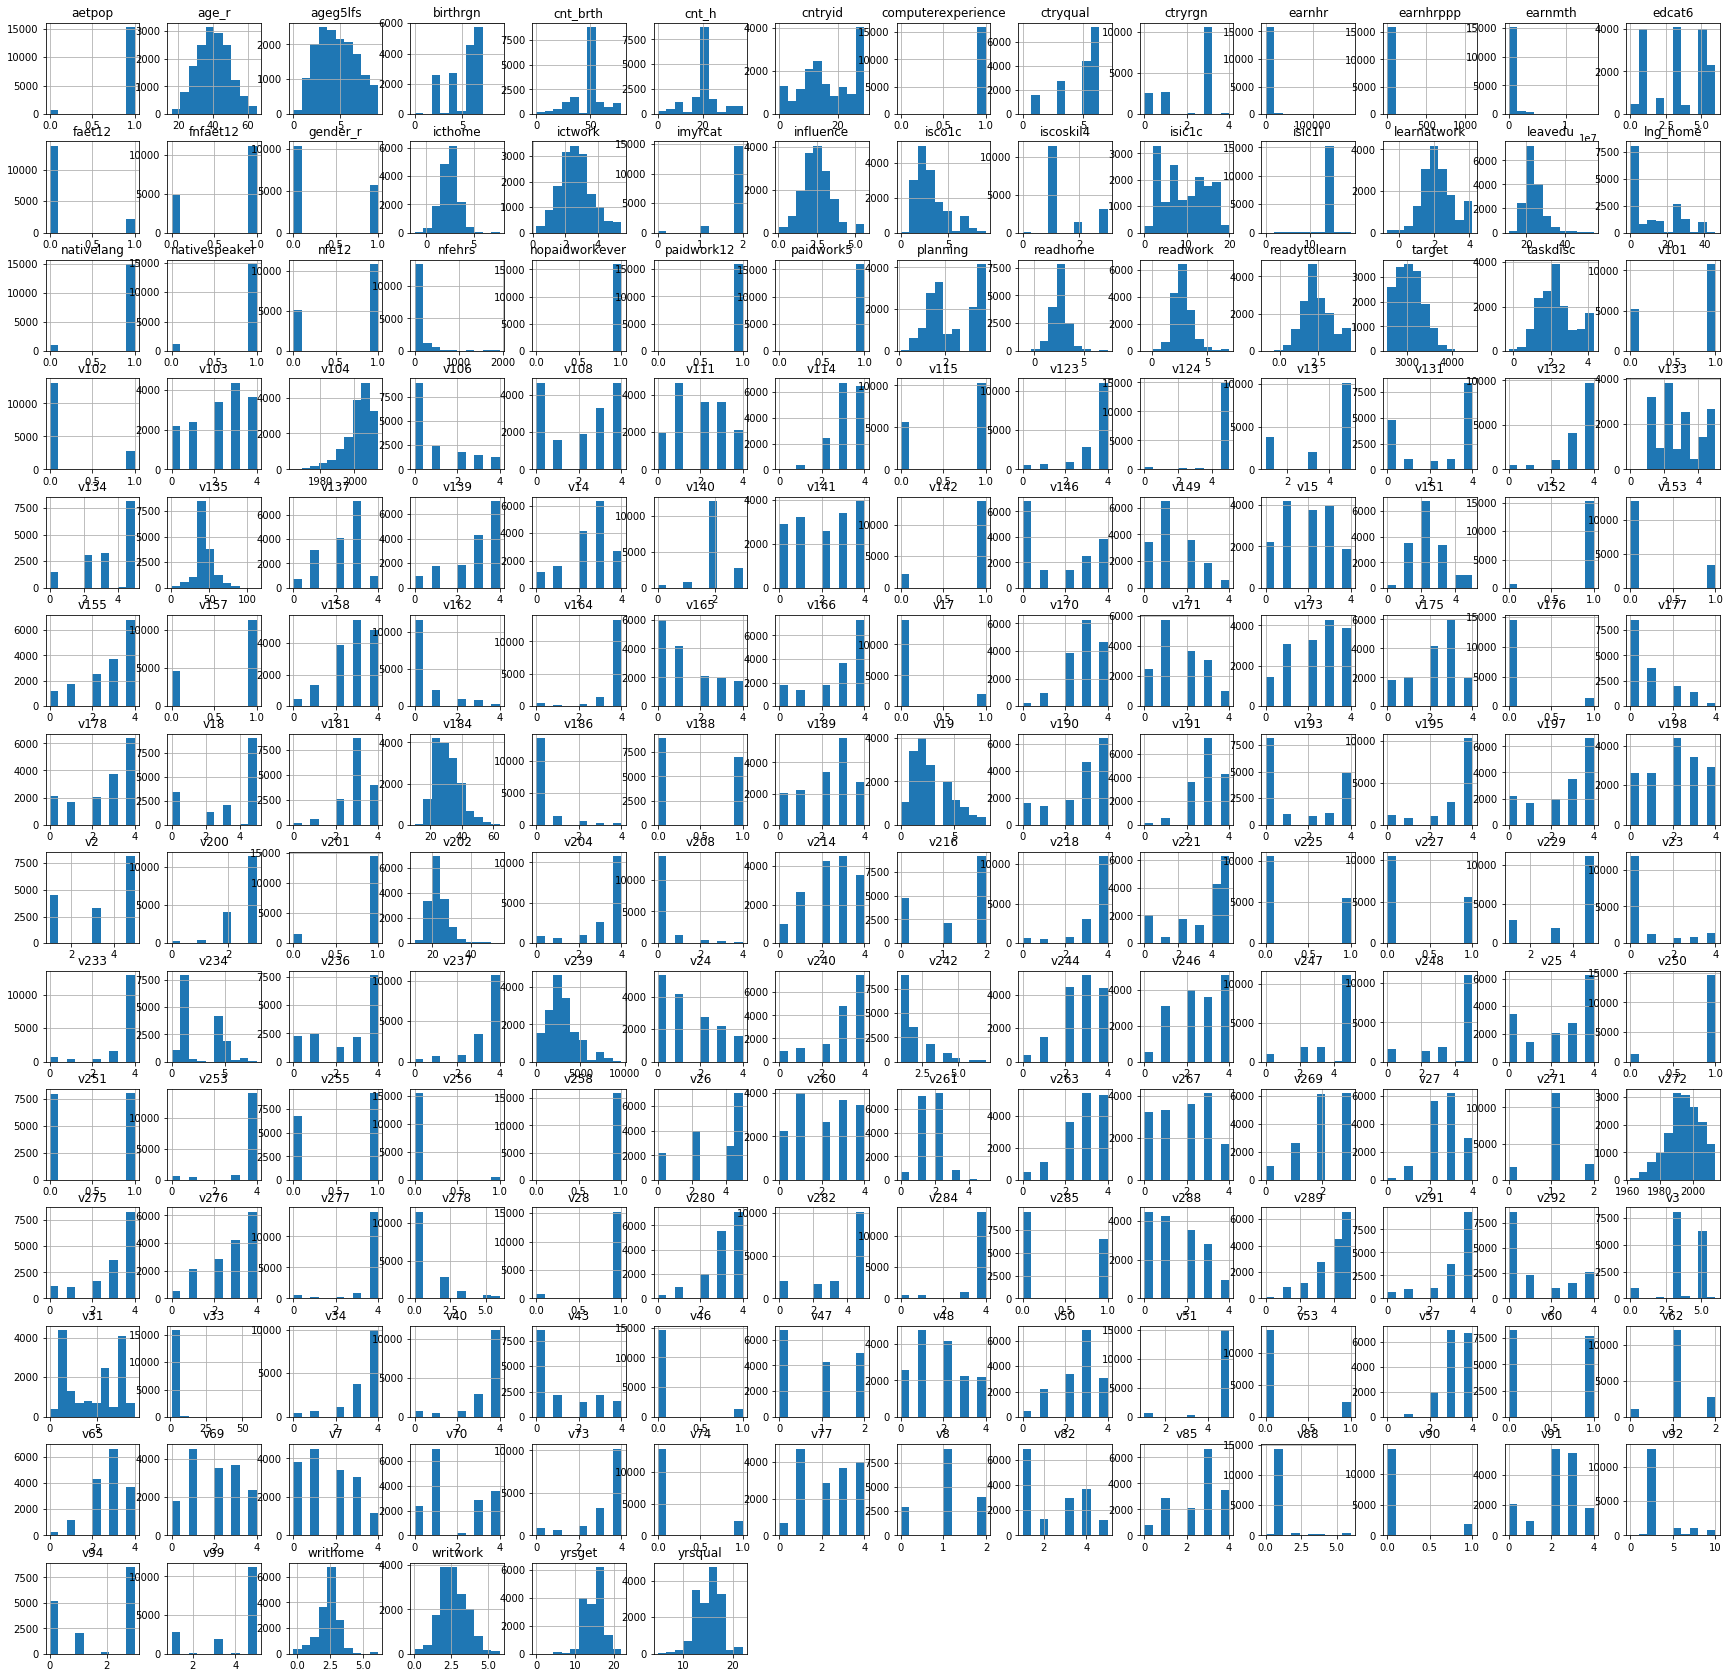

In [0]:
fig, ax = plt.subplots(figsize=(30, 30))
df.hist(ax=ax)
plt.show()

## Feature Selection

### Using univariate statistics for feature selection

In [0]:
selected_features = univariate_feature_selection_with_GUS(df)
df = pd.DataFrame(selected_features)
df.head()

Elapsed Time for feature selection: 204.55848736299959s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,3.0,3.0,1.0,3.0,0.0,3.0,1.0,4.0,3.0,1.0,4.0,1.0,4.0,0.0,2.0,2.0,9.0,5.0,4.0,3.0,5.0,2.0,6.0,28.0,10.0,22.0,75.0,2.0,1.0,0.0,3.0,2.0,60.0,15.0,13.2,21.0,40.0,3.0,22.231706,28.169953,3825.800000,1.566713,2.570880,3.538845,2.237029,1.912440,1.958027,3.663056,3.299227,1.106760,3.116459,3.101801,21.0,1972.0,4.0,4.0,4.0,40.6,2002.2,40.0,3118.0,2866.885957
1,3.0,2.0,2.0,1.0,4.0,3.0,2.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,3.0,2.0,3.0,5.0,5.0,1.0,3.0,4.0,4.0,28.0,10.0,22.0,75.0,3.0,8.0,1.0,4.0,2.0,31.0,16.0,16.0,25.0,40.0,2.0,24.786325,36.554570,4833.333333,1.439648,2.955430,2.624791,2.067996,2.063495,1.958027,2.513366,2.146608,1.181746,2.979574,2.818857,24.0,2004.0,2.0,3.0,3.0,30.0,2004.0,50.0,2421.0,2871.232434
2,4.0,3.0,2.0,2.0,0.0,2.0,1.0,3.0,4.0,3.0,3.0,3.0,2.0,4.0,3.0,4.0,3.0,2.0,3.0,2.0,3.0,1.0,5.0,19.0,35.0,22.0,50.0,13.0,8.0,5.0,4.0,2.0,33.0,18.0,13.4,31.0,320.0,3.0,179.411064,26.943190,35716.666667,1.861184,1.555305,3.479338,4.466779,2.793739,1.647927,3.612399,2.530622,1.181746,3.036055,3.690521,31.0,2008.0,2.0,2.0,2.0,34.6,2006.2,40.0,334.0,2601.625461
3,4.0,3.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,21.0,1.0,22.0,57.0,6.0,2.0,1.0,2.0,2.0,22.0,11.0,12.0,19.0,2.0,3.0,57.803468,3.193445,12000.000000,2.158957,2.361803,3.124378,1.068533,0.790144,1.752098,2.075520,0.725462,1.317258,1.685187,2.326391,17.0,2006.0,2.0,3.0,3.0,21.0,2010.0,48.0,3313.0,3197.167530
4,2.0,3.0,4.0,1.0,4.0,2.0,1.0,3.0,2.0,2.0,4.0,1.0,2.0,1.0,1.0,2.0,2.0,4.0,4.0,2.0,2.0,1.0,3.0,27.0,1.0,35.0,72.0,16.0,6.0,4.0,2.0,2.0,29.0,14.0,14.0,24.0,80.0,2.0,9.743364,14.664138,1246.666667,1.410502,2.128240,2.651897,1.821611,2.717313,1.752098,2.683166,2.130538,1.872176,2.949319,2.006123,24.0,2009.0,2.2,1.0,1.0,25.4,2005.8,25.0,2341.0,2627.234538


In [0]:
df.rename({61:"target"}, axis=1, inplace=True)

## Split up the data

In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(df)

Training features shape: (11185, 61)
Validation features shape: (3192, 61)
Test features shape: (1598, 61)


## Standardize Data

In [0]:
scaled_X_train, scaled_X_val, scaled_X_test = standardize_data(X_train, X_val, X_test)

## Simple MLP Model with Regularization

In [0]:
K.clear_session()
model = get_compiled_model(y_train)

In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_mae:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mae', verbose = 0, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint, early_stopping]

In [0]:
BATCH_SIZE=int(np.ceil(scaled_X_train.shape[0]/100))
STEPS_PER_EPOCH = scaled_X_train.shape[0]/BATCH_SIZE
EPOCHS = 500

model.load_weights(initial_weights)

history = model.fit(
    scaled_X_train,
    y_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(scaled_X_val, y_val), # manual selection of validation dataset
    verbose=0,
    callbacks=callbacks_list)

Restoring model weights from the end of the best epoch.
Epoch 00207: early stopping


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               7936      
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 128)               512       
_________________________________________________________________
dropout_final (Dropout)      (None, 128)               0

In [0]:
for idx, key in enumerate(history.history.keys()):
    print(f"{key}: {np.mean(history.history[key]):.3f}")

loss: 790.236
mse: 52933.555
mae: 175.709
rmse: 229.261
val_loss: 784.356
val_mse: 52073.965
val_mae: 170.115
val_rmse: 227.232


In [0]:
# evaluate on val
results_val = model.evaluate(scaled_X_val, y_val, verbose=0) # batch_size=BATCH_SIZE
for metric, res  in zip(["val_loss", "val_mse", "val_mae", "val_rmse"], results_val):
    print(f"{metric}: {res:.3f}")

val_loss: 768.600
val_mse: 45298.555
val_mae: 153.792
val_rmse: 212.876


In [0]:
# evaluate on test
results_test = model.evaluate(scaled_X_test, y_test, verbose=0) # batch_size=BATCH_SIZE
for metric, res  in zip(["test_loss", "test_mse", "test_mae", "test_rmse"], results_test):
    print(f"{metric}: {res:.3f}")

test_loss: 767.218
test_mse: 45570.410
test_mae: 152.460
test_rmse: 213.419


In [0]:
np.std(y_test)

293.65114432684686

In [0]:
y_pred = model.predict(scaled_X_test)

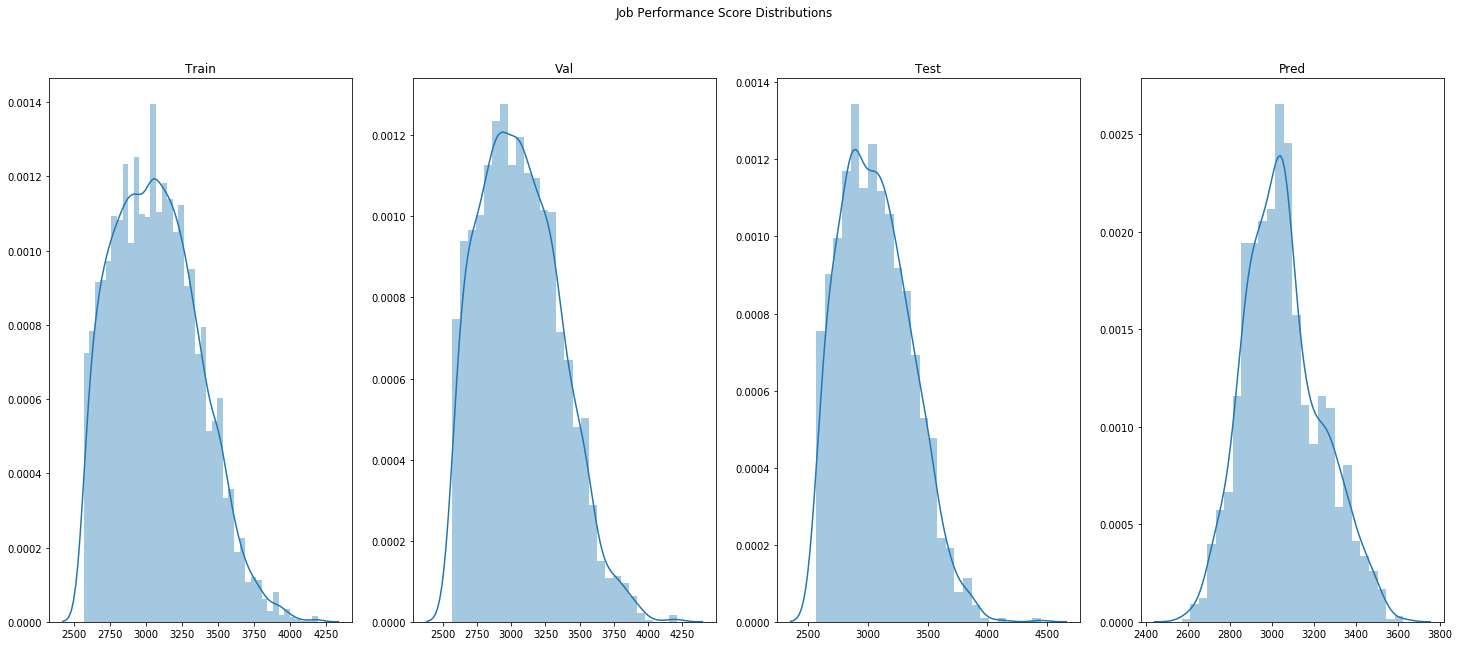

In [0]:
plot_label_results(y_train, y_val, y_test, y_pred)

In [0]:
kruskal_test(y_test, y_pred)

We fail to reject the null hypothesis and conclude that the population medians are not different.


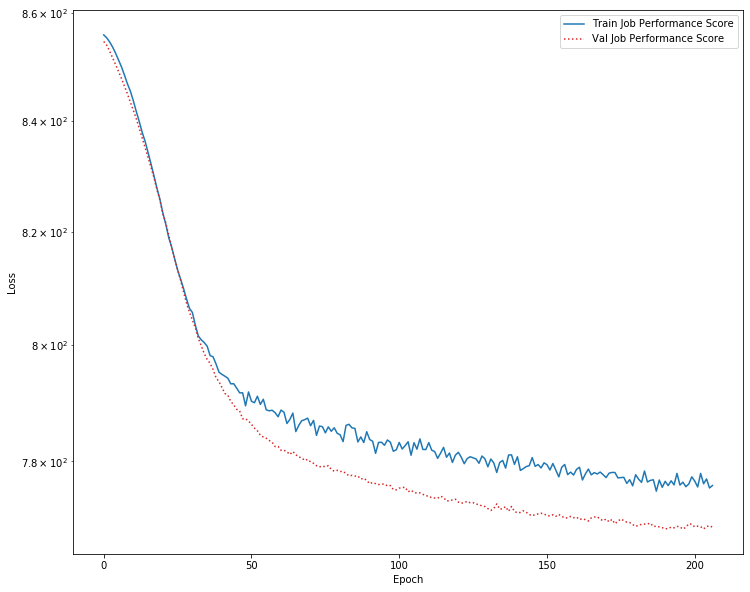

In [0]:
plot_loss(history, label="Job Performance Score", n=2)

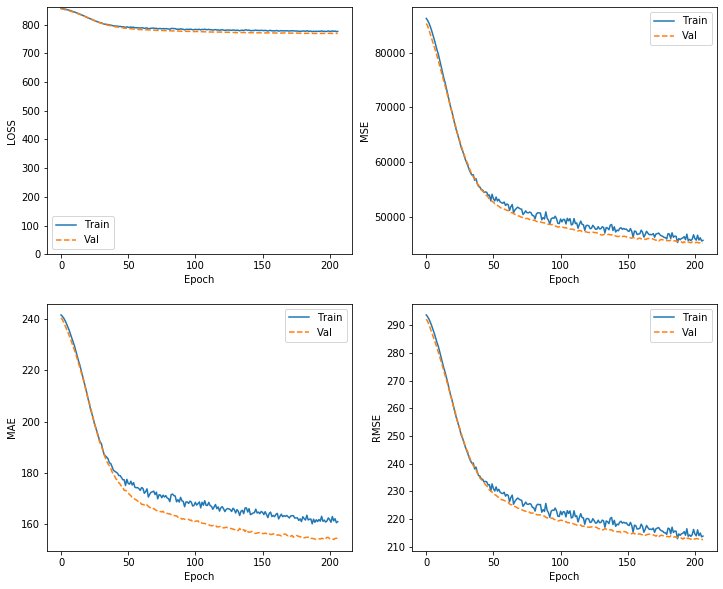

In [0]:
plot_metrics(history)

In [0]:
make_submission(y_pred,'mlp_predictions.csv')

A submission file has been made
